In [ ]:
!pip install -U --pre tensorflow=="2.8.0"

     |████████████████████████████████| 462 kB 32.3 MB/s 


In [ ]:
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3328, done.
remote: Counting objects: 100% (3328/3328), done.
remote: Compressing objects: 100% (2754/2754), done.
remote: Total 3328 (delta 882), reused 1386 (delta 524), pack-reused 0
Receiving objects: 100% (3328/3328), 34.31 MiB | 12.06 MiB/s, done.
Resolving deltas: 100% (882/882), done.


In [ ]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1691106 sha256=7dbf8ffeca3408ec1d4faeee76e726e51f3018af470fbd5f4bb7e5d072f814c9
  Stored in directory: /tmp/pip-ephem-wheel-cache-z3pr4jhk/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=76d8859501c176ebd0ec89c303efccd57ee97556776ad6ea69c857cbf3b7d2b8
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78544 sha256=2cce1594f9cc387ac46c0133dca28b5c83f907c5c14aaf96a1df56c69bcac315
  Stored in directory: /root/.cache/pip/wheels/a4/61/fd/c57e374e580aa78a45ed78d5859b3a44436af17e22ca53284f
  Created wheel for avro-python3: filename=avro_python3-1.10.2-py3-none-any.whl size=44010 sha256=02a23c1bbb64ce3c2f992fbad82049ca38eed21fef2124fb9a

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
gym 0.17.3 requires cloudpickle<1.7.0,>=1.2.0, but you have cloudpickle 2.0.0 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Utilities

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Args:
    path: a file path.
  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)


In [ ]:
# Load images and visualize
# Renaming train_images_np to train_empty_images_np
train_image_dir = '/content/drive/MyDrive/beer_tracking/training_images'
train_empty_images_np = []
train_full_images_np = []

for filename in os.listdir(train_image_dir):
  if filename.startswith('empty') and os.path.isfile(os.path.join(train_image_dir, filename)):
    train_empty_images_np.append(load_image_into_numpy_array(os.path.join(train_image_dir, filename)))
  elif filename.startswith('full') and os.path.isfile(os.path.join(train_image_dir, filename)):
    train_full_images_np.append(load_image_into_numpy_array(os.path.join(train_image_dir, filename)))


plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]



## Visualizing the images

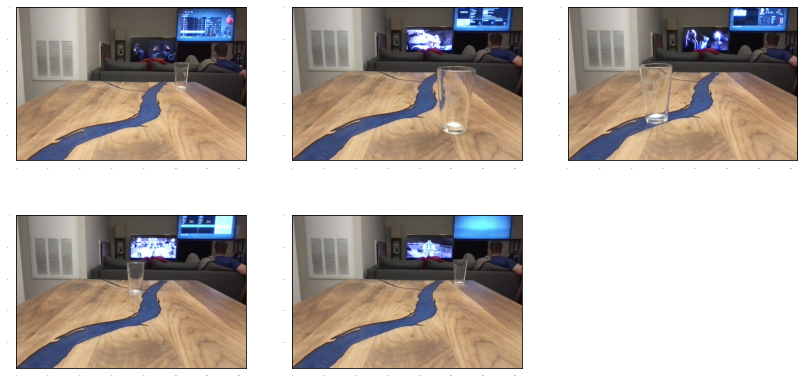

In [ ]:
for idx, train_image_np in enumerate(train_empty_images_np):
  plt.subplot(2, 3, idx+1)
  plt.imshow(train_image_np)
plt.show()

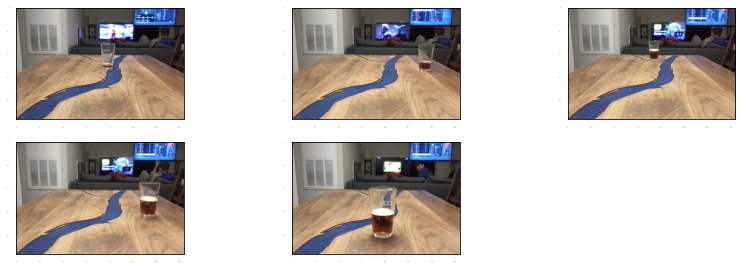

In [ ]:
for idx, train_image_np in enumerate(train_full_images_np):
  plt.subplot(2, 3, idx+1)
  plt.imshow(train_image_np)
plt.show()

In [ ]:
# Load from text if we can
gt_box_path = '/content/drive/MyDrive/beer_tracking/gt_boxes'
gt_empty_boxes = []
gt_full_boxes = []

if os.path.exists(gt_box_path + '/emptyArray.npy'):
  gt_empty_boxes = np.load(gt_box_path + '/emptyArray.npy')
else:
  print('Nothing for empty')
  
if os.path.exists(gt_box_path + '/fullArray.npy'):
  gt_full_boxes = np.load(gt_box_path + '/fullArray.npy')
else:
  print('Nothing for full')

empty:  [[[0.26796875 0.375      0.60130208 0.546875  ]]

 [[0.26130208 0.5171875  0.63130208 0.6828125 ]]

 [[0.11963542 0.5484375  0.56796875 0.7390625 ]]

 [[0.43130208 0.325      0.91630208 0.521875  ]]

 [[0.20463542 0.4015625  0.69463542 0.625     ]]]
full:  [[[0.20630208 0.3625     0.92296875 0.7140625 ]]

 [[0.29463542 0.4640625  0.77130208 0.6609375 ]]

 [[0.17130208 0.5703125  0.48630208 0.70625   ]]

 [[0.17463542 0.3734375  0.80296875 0.6296875 ]]

 [[0.39130208 0.1484375  0.73630208 0.334375  ]]

 [[0.20963542 0.2953125  0.53630208 0.4375    ]]

 [[0.12630208 0.553125   0.48963542 0.7125    ]]]


# Annotate images with bounding boxes (Only needed if we couldn't load gt_boxes)



In [ ]:
# Renaming gt_boxes to gt_empty_boxes
# Renaming train_images_np to train_empty_images_np
gt_empty_boxes = []
colab_utils.annotate(train_empty_images_np, box_storage_pointer=gt_empty_boxes)
print(gt_empty_boxes)

<IPython.core.display.Javascript object>

[]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [ ]:
gt_full_boxes = []
colab_utils.annotate(train_full_images_np, box_storage_pointer=gt_full_boxes)
print(gt_full_boxes)

<IPython.core.display.Javascript object>

[]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

## Saving annotations

In [ ]:
with open('fullArray.npy', 'wb') as f:
  np.save(f, gt_full_boxes)
with open('emptyArray.npy', 'wb') as f:
  np.save(f, gt_empty_boxes)

# Prepare data for training


## This is the code that has been working to train one class at a time

In [ ]:

# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
empty_class_id = 1
# full_class_id = 1
# Change this if you're trying to train for more than one class at a time
num_classes = 1

category_index = {empty_class_id: {'id': empty_class_id, 'name': 'empty_glass'}}
# category_index = {full_class_id: {'id': full_class_id, 'name': 'full_glass'}}
# category_index = {empty_class_id: {'id': empty_class_id, 'name': 'empty_glass'}, 
#                   full_class_id: {'id': full_class_id, 'name': 'full_glass'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_empty_images_np, gt_empty_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')


Done prepping data.


## Attempting to add two classes

In [ ]:
from tensorflow.python.ops.gen_array_ops import empty

# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
empty_class_id = 1
full_class_id = 2
# Change this if you're trying to train for more than one class at a time
num_classes = 2

# category_index = {empty_class_id: {'id': empty_class_id, 'name': 'empty_glass'}}
# category_index = {full_class_id: {'id': full_class_id, 'name': 'full_glass'}}
category_index = {empty_class_id: {'id': empty_class_id, 'name': 'empty_glass'}, 
                  full_class_id: {'id': full_class_id, 'name': 'full_glass'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
#TODO might need to be changed to 2
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_empty_images_np, gt_empty_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.zeros(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset + empty_class_id)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
for (train_image_np, gt_box_np) in zip(
    train_full_images_np, gt_full_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.zeros(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset + full_class_id)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

Done prepping data.


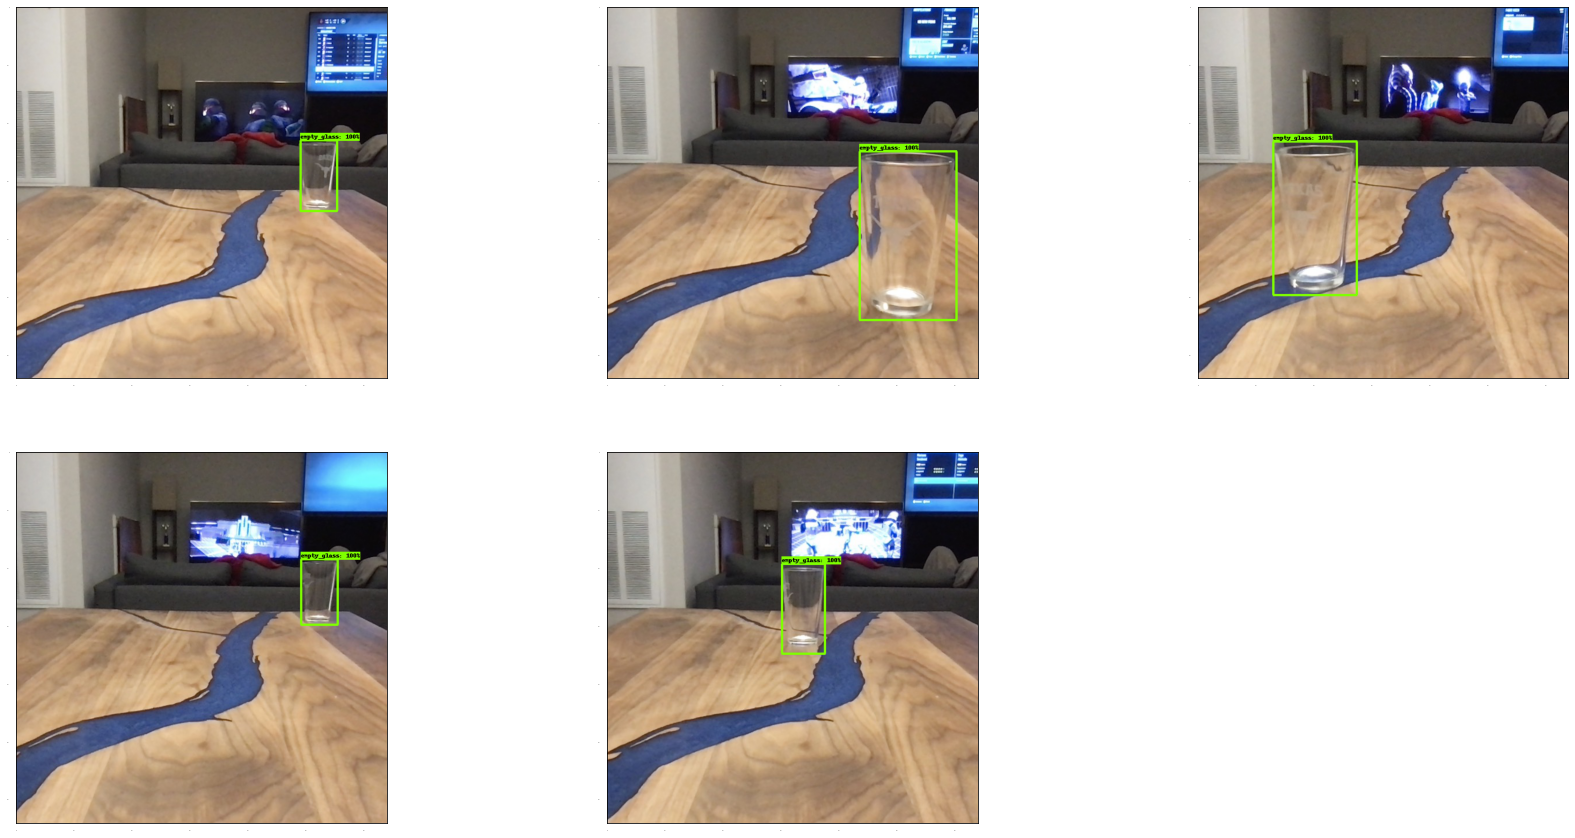

In [ ]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_empty_images_np[idx],
      gt_empty_boxes[idx],
      np.ones(shape=[gt_empty_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

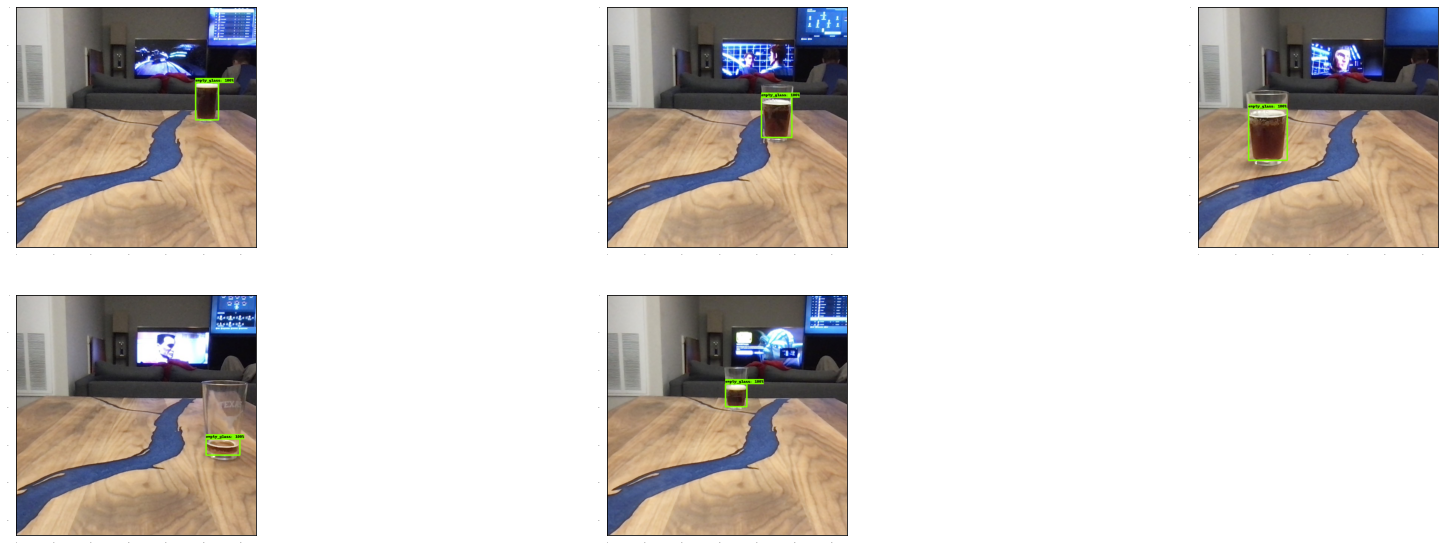

In [ ]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(3, 3, idx+1)
  plot_detections(
      train_full_images_np[idx],
      gt_full_boxes[idx],
      np.ones(shape=[gt_full_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

# Create model 

In [ ]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2022-04-25 20:38:34--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.194.128, 2404:6800:4003:c04::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.194.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M  50.2MB/s    in 4.7s    

2022-04-25 20:38:40 (50.2 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [ ]:
!wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_11_06_2017.tar.gz
!tar -xf ssd_mobilenet_v1_coco_11_06_2017.tar.gz
!mv ssd_mobilenet_v1_coco_11_06_2017-8/checkpoint models/research/object_detection/test_data/

--2022-04-25 20:50:38--  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_11_06_2017.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.194.128, 2404:6800:4003:c04::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.194.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128048406 (122M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v1_coco_11_06_2017.tar.gz’

ssd_mobilenet_v1_co 100%[===================>] 122.12M  22.5MB/s    in 5.4s    

2022-04-25 20:50:45 (22.5 MB/s) - ‘ssd_mobilenet_v1_coco_11_06_2017.tar.gz’ saved [128048406/128048406]

mv: cannot stat 'ssd_mobilenet_v1_coco_11_06_2017-8/checkpoint': No such file or directory


In [ ]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
# num_classes = 1
num_classes = 2
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
# pipeline_config = '/content/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/pipeline.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'
# checkpoint_path = '/content/ssd_mobilenet_v1_coco_11_06_2017/model.ckpt'

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


In [ ]:
# For second round of training
# detection_model = new_model
print(type(detection_model))
print(type(new_model))

<class 'object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch'>
<class 'tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject'>


# Eager mode custom training loop



In [ ]:
tf.keras.backend.set_learning_phase(True)

total_images = len(train_empty_images_np) + len(train_full_images_np)

batch_size = 4
learning_rate = 0.01
num_batches = 100

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  all_keys = list(range(total_images))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]


  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!


/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


batch 0 of 100, loss=1.472512


batch 10 of 100, loss=0.53324115
batch 20 of 100, loss=0.3545103
batch 30 of 100, loss=0.24871668
batch 40 of 100, loss=0.20655687
batch 50 of 100, loss=0.20239475
batch 60 of 100, loss=0.34643713
batch 70 of 100, loss=0.43920052
batch 80 of 100, loss=0.2167798
batch 90 of 100, loss=0.18173948
Done fine-tuning!


In [ ]:
@tf.function(input_signature=[tf.TensorSpec(shape=[None,640,640,3], dtype=tf.float32)])
def detect(input_tensor):
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

In [ ]:
# import pickle
print(type(detection_model))
# pickle.dump(detection_model, open('model.pkl', 'wb'))

# tf.saved_model.save(detection_model, 'myModel')
tf.saved_model.save(detection_model, 'myModel', 
                    signatures={'detect': detect.get_concrete_function()})

<class 'object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch'>


INFO:tensorflow:Assets written to: myModel/assets


INFO:tensorflow:Assets written to: myModel/assets


In [ ]:
# Code for loading the model saved in the previous cell
new_model=tf.saved_model.load('/content/myModel')
print(type(new_model))
# detections= new_model.signatures[ 'detect' ]( "your_detection_img_tensor" )

<class 'tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject'>


# Load test images and run inference with new model!

In [ ]:
# Our attempt to predict on a loaded image
image_path = '/content/drive/MyDrive/beer_tracking/test_images/test_full.jpg'
image_np = np.expand_dims(load_image_into_numpy_array(image_path), axis=0)
input_tensor = tf.convert_to_tensor(image_np, dtype=tf.float32)
detections = new_model.signatures[ 'detect' ](input_tensor)
plot_detections(
      image_np[0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="one.jpg")
plt.show()

In [ ]:

for i in range(detections['detection_scores'].numpy()[0].shape[0]):
  score = detections['detection_scores'].numpy()[0][i]
  if score > .5:
    print(detections['detection_classes'].numpy()[0][i], score)

1.0 0.90891486


In [ ]:
%%bash
cp -r myModel drive/MyDrive/beer_tracking/

In [ ]:
type(input_tensor)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
category_index

{1: {'id': 1, 'name': 'empty_glass'}, 2: {'id': 2, 'name': 'full_glass'}}